In [117]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

In [9]:
def np_dot(a, b):
  return np.dot(a,b)

def norm(a):
  return np.linalg.norm(a)

In [10]:
def func(x):
  """
  Функция произвольного
  вида от вектора х.
  """

  x = np.asarray(x).reshape(-1)
  A = np.eye((x.shape[0]))
  b = np.ones_like(x)
  c = 0
  
  return np_dot(np_dot(A,x),x) + np_dot(b,x) + c

In [11]:
def get_grad(functor, x_0):
  """
  Принимаем на вход функтор и
  координаты точки x_0,
  возвращаем градиент 
  (вектор столбец)
  в этой точке.
  """
  
  eps = 1e-9
  x_0 = np.asarray(x_0, dtype=float).reshape(-1)
  f_grad = np.zeros_like(x_0)

  for i in range(x_0.shape[0]):
    x_plus = x_0.copy()
    x_plus[i] += eps

    x_minus = x_0.copy()
    x_minus[i] -= eps

    f_grad[i] = functor(x_plus) - functor(x_minus)
    f_grad[i] /= 2*eps

  return f_grad.reshape(-1,1)

In [3]:
import time

In [5]:
def DFP_method(func, x, eps=1e-9, logging=False):

  # Help function for leraning rate searching.
  #
  def one_dim_min(f, x_cur, d_cur):
    """
    One-dimensional minimization rule.

    Ищем lr с помощью градиентного спуска 
     с шагом lrlr, который уменьшается со временем.
    """

    lr = 0.5
    lrlr = 0.1
    f_from_lr = lambda lr: f(x_cur - lr * d_cur)
    fx_prev = np_dot(get_grad(f_from_lr, lr).T, lr) # <f',x>

    for _ in range(10000):          
      th = 1
      lr_d_cur = np.clip(get_grad(f_from_lr, lr), -th, th)[0,0]
      lr = lr - lrlr * lr_d_cur
      fx_next = np_dot(get_grad(f_from_lr, lr).T, lr)
      if fx_next * fx_prev > 0: # Если направление движения не меняется увеличиваем шаг, иначе уменьшаем.
        lrlr *= 1.2
      else:
        lrlr *= 0.6
      fx_prev = fx_next
      # print()
      # print('lr: %.4f' % lr)
      # print('norm lr_d: %.12f' % norm(lr_d_cur))
      # print(eps)
      # print("f\' = %.2f" % fx_next)
      # print('lrlr: %.4f' % lrlr)
      if norm(lr_d_cur) < eps:
        break
      #time.sleep(4)

    return lr


  x = np.asarray(x).reshape(-1,1)

  if logging:
    i = 1

  while norm(get_grad(func, x)) > eps:    

    if logging:
      print('%i-st step of DFP:' % i)
    i+=1

    if logging:
      print("f(x) = %.6f" % func(x))
      #print("f\' = %.6f" % np_dot(get_grad(func, x).T, x))
      print("||f\'|| = %.6f" % norm(get_grad(func, x)))

    Q = np.diag([1.]*x.shape[0])

    x_prev = x
    f_grad_prev = get_grad(func, x_prev)

    d = -np_dot(Q, f_grad_prev)
    lr = one_dim_min(func, x_prev, f_grad_prev) # Ищем длину шага.
    #lr = 0.0001
    if logging:
      print('lr = %.4f' % lr)
    x_next = x_prev + lr * d  
    f_grad_next = get_grad(func, x_next)

    if logging:
      print('<f\'next, f\'prev> = %.9f' % np_dot(f_grad_next.T, f_grad_prev)) # Проверяем оротогональны ли напр-ия.

    r = x_next - x_prev
    s = f_grad_next - f_grad_prev

    Q_s = np_dot(Q, s)
    Q += np_dot(r, r.T) / np_dot(r.T, s)
    Q -= np_dot(Q_s, Q_s.T) / np_dot(Q_s, s.T)

    x = x_next    

    if logging:
      print('step has been taken', end='\n\n')
  
  if logging:
    print('DFP method converged.', end='\n\n')

  return x  

In [104]:
def DFP_method(func, x, eps=1e-9, logging=False, iter_max=float("inf")):

  x = np.asarray(x).reshape(-1,1)
  lr = 0.001

  iter_num = 0
  
  f_grad_prev = get_grad(func, x)

  while norm(get_grad(func, x)) > eps and iter_num < iter_max:    

    if logging:
      print('%i-st step of DFP:' % (iter_num + 1))
    iter_num += 1

    if logging:
      print("f(x) = %.6f" % func(x))
      print("||f\'|| = %.6f" % norm(get_grad(func, x)))

    Q = np.diag([1.]*x.shape[0])

    x_prev = x

    if np_dot(f_grad_prev.T, get_grad(func, x_prev)) > 0: # Если направление движения не меняется увеличиваем шаг, иначе уменьшаем.
      #if i < 10000000:
      lr *= 1.2
    else:
      lr *= 0.6

    f_grad_prev = np.clip(get_grad(func, x_prev), -1, 1)

    d = -np_dot(Q, f_grad_prev)
    #lr = one_dim_min(func, x_prev, f_grad_prev) # Ищем длину шага.
    if logging:
      print('lr = %.5f' % lr)
    x_next = x_prev + lr * d  
    f_grad_next = get_grad(func, x_next)

    if logging:
      print('<f\'next, f\'prev> = %.9f' % np_dot(f_grad_next.T, f_grad_prev)) # Проверяем оротогональны ли напр-ия.

    r = x_next - x_prev
    s = f_grad_next - f_grad_prev

    Q_s = np_dot(Q, s)
    Q += np_dot(r, r.T) / np_dot(r.T, s)
    Q -= np_dot(Q_s, Q_s.T) / np_dot(Q_s, s.T)

    x = x_next    

    if logging:
      print('step has been taken', end='\n\n')
  
  if logging:
    print('DFP method converged.', end='\n\n')

  return x  

In [ ]:
x_0 = [-5, 10]
x = DFP_method(func, x_0, eps=1e-6, logging=True)
print(func(x), '\n', x)

In [13]:
def g_1(x):

  x = np.asarray(x).reshape(2,1)
  const = np.array([1,1]).reshape(2,1)

  return np.float(np_dot(const.T, x))

In [14]:
def g_2(x):

  x = np.asarray(x).reshape(2,1)
  const = np.array([1,-1]).reshape(2,1)

  return np.float(np_dot(const.T, x))

In [15]:
def f(x):

  x = np.asarray(x).reshape(2,1)
  const = np.array([10, 9]).reshape(2,1)

  x = x + const
  return np.float(np_dot(x.T, x))

In [223]:
def Find_optim(func, x, g_list = [], h_list = [], p=2, r=1, beta=2, eps=1e-6, logging=False, iter_max=float("inf"), DFP_iter_max=float("inf")):
  """
  x  - начальная точка.
  func - функция, минимум которой мы ищем.
  g_list - список функций-ограничений типа нер-во (>= 0).
  h_list - список функций-ограничений типа равенство.
  p - показатель степени (см. Z_func).
  r - начальное значение параметра штрафа.
  beta - коэф-нт в формуле вычисления параметра штрафа.
  eps  - условия останова, ограничение на ||f'||.
  logging - выводить логи работы или нет.
  iter_max - максимальное кол-во итераций.
  DFP_iter_max - максимальное кол-во итераций для метода DFP.

  return точку x_optim, в кот-ой достигается условный оптимум func и pd.DataFrame с логами.
  """

  x_shape = len(x.reshape(-1))

  column_names = {'Z_value': [], 'F_value': [], 'alpha_value': [], 'r': []}
  column_names.update({'x['+str(i)+']': [] for i in range(x_shape)})

  logging_df = pd.DataFrame(column_names)

  # 2-nd part in Z_func, func - 1st.
  #
  def alpha_func(x, p=p): 

    alpha_func_val = 0    
    for g_func in g_list:
      alpha_func_val += max(0, - g_func(x)) ** p  

    for h_func in h_list:
      alpha_func_val += abs(h_list(x)) ** p
    
    return alpha_func_val

  
  # Main function for finding the optimum.
  #
  def Z_func(x):
    return func(x) + r * alpha_func(x)

  # Function for logging.
  #
  def penalty_logging(x, r):
    print('current iter №%i' % (iter_num+1))
    print('curr Z_val: %.5f, from' % Z_func(x))
    print('curr optim point: ', end='')
    for x_coor in x: print('%.3f  ' % x_coor, end='')
    print('\nr =', r)
    print('alpha(x) = %.10f' % alpha_func(x))
    print('-'*30)
    #time.sleep(3)

  iter_num = 0
  if logging:
    print('Search has started!')
    print('-'*30)

  x = DFP_method(Z_func, x, eps, logging=logging, iter_max=DFP_iter_max)

  if logging:
    penalty_logging(x, r)

  new_line = {'Z_value': Z_func(x), 'F_value': func(x), 'alpha_value': alpha_func(x), 'r': r}
  new_line.update({'x['+str(i)+']': x.reshape(-1)[i] for i in range(x_shape)})
  logging_df = logging_df.append(pd.DataFrame(new_line, index=[iter_num]))
  

  while r*alpha_func(x) > eps and iter_num < iter_max:

    iter_num += 1
    r = (r**2 + beta)**0.5
    x = DFP_method(Z_func, x, eps, logging=logging, iter_max=DFP_iter_max)

    if logging:
      penalty_logging(x, r)

    new_line = {'Z_value': Z_func(x), 'F_value': func(x), 'alpha_value': alpha_func(x), 'r': r}
    new_line.update({'x['+str(i)+']': x.reshape(-1)[i] for i in range(x_shape)})
    logging_df = logging_df.append(pd.DataFrame(new_line, index=[iter_num]))

  if logging:
    print('Search has ended!')
  
  return x, logging_df

In [224]:
%%time
x_0 = np.array([[2],[-1]])

x_optim, logging_df = Find_optim(func, x_0, [g_1, g_2], eps=1e-6, r=0.01, beta=100, logging=False, iter_max=1000)
x_optim

CPU times: user 4.47 s, sys: 0 ns, total: 4.47 s
Wall time: 4.48 s


In [225]:
logging_df

,Z_value,F_value,alpha_value,r,x[0],x[1]
0,-0.490196,-0.499808,0.961169,0.010000,-0.490196,-0.490196
1,-0.023810,-0.046485,0.002268,10.000005,-0.023809,-0.023810
2,-0.017074,-0.033565,0.001166,14.142139,-0.017074,-0.017074
3,-0.014029,-0.027664,0.000787,17.320511,-0.014029,-0.014029
4,-0.012195,-0.024093,0.000595,20.000002,-0.012195,-0.012195
...,...,...,...,...,...,...
996,-0.000791,-0.001581,0.000003,315.594677,-0.000791,-0.000791
997,-0.000791,-0.001580,0.000002,315.753068,-0.000791,-0.000791
998,-0.000790,-0.001579,0.000002,315.911380,-0.000790,-0.000790
999,-0.000790,-0.001578,0.000002,316.069613,-0.000790,-0.000790


In [226]:
def J(x):
  res = 0
  x = np.asarray(x)
  for i in range(1,x.shape[0]):
    res += (x[i] - i*x[0])**4
  res = res**6 + (x[0] - 2)**4

  return np.float(res)

In [227]:
def g1(x):
  x = np.asarray(x)
  return np.float(-((x**2).sum()**6 - 363)) # >= 0

In [228]:
%%time
x_0 = np.array([[2.],[1.6],[3.5]])
#x_0 = np.array([[5.],[3.],[-1.2]])

x_optim, logging_df = Find_optim(J, x_0, [g1], eps=1e-9, p=2, r=0.01, beta=1, logging=False, iter_max=10, DFP_iter_max=100)
x_optim

CPU times: user 535 ms, sys: 0 ns, total: 535 ms
Wall time: 537 ms


In [230]:
logging_df

,Z_value,F_value,alpha_value,r,x[0],x[1],x[2]
0,1.019827,1.019811,1.603538e-03,0.010000,1.007166,0.285947,1.254894
1,1.019839,1.019838,1.128408e-06,1.000050,1.007478,0.285458,1.254736
2,1.019701,1.019701,4.332882e-08,1.414249,1.007666,0.285454,1.254586
3,1.019160,1.019160,5.833064e-08,1.732080,1.008435,0.285539,1.253949
4,1.018502,1.018502,5.393243e-08,2.000025,1.008913,0.286256,1.253400
5,1.017964,1.017964,1.802084e-08,2.236090,1.009281,0.286902,1.252956
6,1.017719,1.017719,1.501065e-08,2.449510,1.009651,0.287085,1.252616
7,1.017524,1.017524,1.151454e-08,2.645770,1.009928,0.287272,1.252350
8,1.017324,1.017324,7.445103e-09,2.828445,1.010118,0.287525,1.252138
9,1.017102,1.017102,1.300494e-08,3.000017,1.010242,0.287847,1.251965


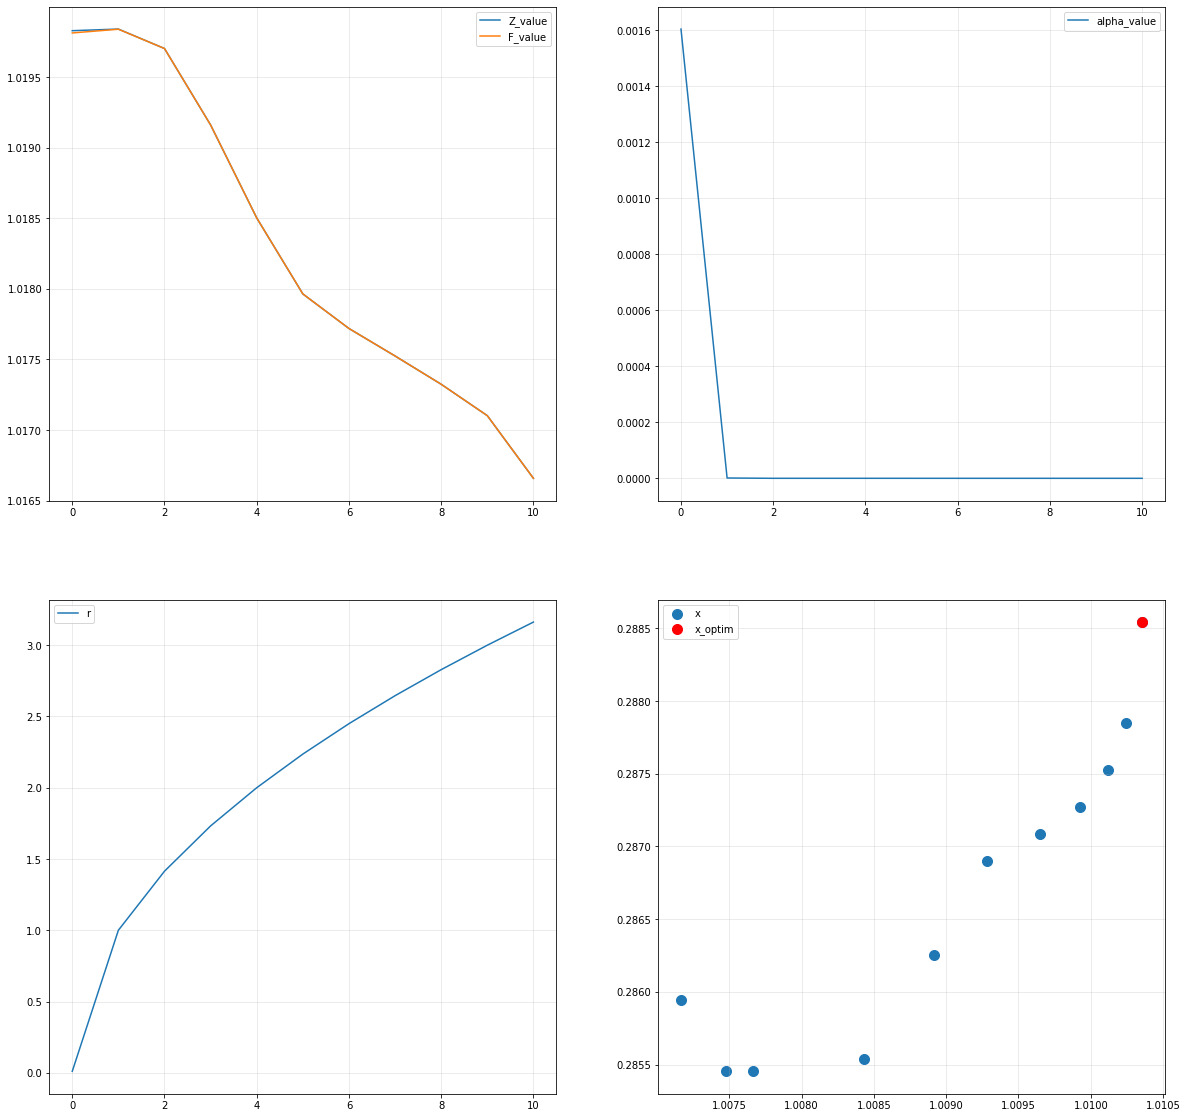

In [278]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2,2, figsize=(20,20))

ax[0,0].plot(logging_df.Z_value,     label='Z_value')
ax[0,0].plot(logging_df.F_value,     label='F_value')
ax[0,1].plot(logging_df.alpha_value, label='alpha_value')
ax[1,0].plot(logging_df.r,           label='r')
ax[1,1].scatter(logging_df['x[0]'], 
                logging_df['x[1]'], 
                label='x',
                s=100)

ax[1,1].scatter(logging_df['x[0]'].tolist()[-1], 
                logging_df['x[1]'].tolist()[-1], 
                label='x_optim',
                s=100, color='red')

for i in range(4):
  ax[i%2,i//2].legend()
  ax[i%2,i//2].grid(alpha=0.3)

plt.show()
plt.close()

1.0103554197670273